# Predicting Job Placement

The goal of our analysis is to derive insights whether a student will ultimately be placed at a company or not. We can idntify that the task is a binary classification problem. We trained Logistic Regression as our baseline model and then added SVM, DecisionTree, RandomForest, and AdaBoost algorithms. Unsurprisingly, XGBoost turned out to be the best model in the pack, leaving Logistic Regression behind by more than 20 percentage points in AUC scores.

The model achieved an AUC of 89.49% in predicting placement through parameter estimation in the training set. I used grid search with 10-fold cross-validation for tuning the parameters. In the held-out validation set, the model achieved an AUC of 87.88%, which matches closely to the expectations estimated during the tuning.

In [1]:
# Import library
import numpy as np
import pandas as pd

# Scipy library
from scipy.stats import norm
from scipy.stats.stats import pearsonr
from scipy.stats.mstats import winsorize

# Sklearn library
from sklearn.metrics import (roc_auc_score,
                             confusion_matrix,
                             plot_confusion_matrix,
                             classification_report)
from sklearn.model_selection import (cross_val_score,
                                     KFold,
                                     GridSearchCV,
                                     train_test_split)
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder)
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import (make_column_transformer,
                             make_column_selector)

# Sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (AdaBoostClassifier, 
                              RandomForestClassifier)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Plotting library
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import seaborn as sns
plt.style.use('ggplot')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load data
raw = pd.read_excel('data_Pathrise.xlsx')
raw.head(5)

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
0,1,Active,SWE,OCT19A,NaN,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American
1,2,Active,PSO,JAN20A,NaN,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American
2,3,Closed Lost,Design,AUG19B,0.0,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American
3,4,Closed Lost,PSO,AUG19B,0.0,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify
4,5,Placed,SWE,AUG19A,89.0,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American


In [3]:
# Inspect the dataset
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2544 entries, 0 to 2543
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           2544 non-null   int64  
 1   pathrise_status              2544 non-null   object 
 2   primary_track                2544 non-null   object 
 3   cohort_tag                   2536 non-null   object 
 4   program_duration_days        1928 non-null   float64
 5   placed                       2544 non-null   int64  
 6   employment_status            2315 non-null   object 
 7   highest_level_of_education   2486 non-null   object 
 8   length_of_job_search         2470 non-null   object 
 9   biggest_challenge_in_search  2520 non-null   object 
 10  professional_experience      2322 non-null   object 
 11  work_authorization_status    2260 non-null   object 
 12  number_of_interviews         2326 non-null   float64
 13  number_of_applicat

We have 2544 instances to work with and quite a good number of missing values. We can also confirm the data has 16 attributes, with 5 being numeric features.

In [4]:
# Check for duplicates
idsUnique = len(set(raw.id))
idsTotal = raw.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 2544 total entries


In [5]:
# Inspect unique values in each feature
raw.nunique()

id                             2544
pathrise_status                   9
primary_track                     6
cohort_tag                       47
program_duration_days           411
placed                            2
employment_status                 5
highest_level_of_education        7
length_of_job_search              5
biggest_challenge_in_search      10
professional_experience           4
work_authorization_status         9
number_of_interviews             21
number_of_applications           41
gender                            4
race                              9
dtype: int64

It seems we can remove the 'id', 'cohort_tag' and 'biggest_challenge_in_search' attributes from our dataset.

In [6]:
# Remove not-so important columns
col_to_drop = ['id', 'cohort_tag', 'biggest_challenge_in_search']
data = raw.copy()
data = data.drop(columns=col_to_drop)
data.sample()

,pathrise_status,primary_track,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
2169,Placed,SWE,136.0,1,Unemployed,Bachelor's Degree,1-2 months,3-4 years,Citizen,0.0,15,Male,South Asian or Indian American


In [7]:
# Summarize the distribution of numeric attributes
data.describe(include=object).T

,count,unique,top,freq
pathrise_status,2544,9,Placed,956
primary_track,2544,6,SWE,1678
employment_status,2315,5,Student,775
highest_level_of_education,2486,7,Bachelor's Degree,1361
length_of_job_search,2470,5,Less than one month,815
professional_experience,2322,4,1-2 years,882
work_authorization_status,2260,9,Citizen,1104
gender,2052,4,Male,1492
race,2526,9,East Asian or Asian American,900


In [8]:
# Summarize the distribution of numeric attributes
data.describe().T

,count,mean,std,min,25%,50%,75%,max
program_duration_days,1928.0,136.098548,125.860248,0.0,14.0,112.0,224.0,548.0
placed,2544.0,0.375786,0.484420,0.0,0.0,0.0,1.0,1.0
number_of_interviews,2326.0,2.182287,2.959273,0.0,0.0,1.0,3.0,20.0
number_of_applications,2544.0,36.500786,53.654896,0.0,9.0,20.0,45.0,1000.0


The data with numeric attributes has very different mean values. However, the date has outliers, especially in 'program_duration_days' and 'number_of_applications' columns. The gap between 75th percentile to max value is huge, which confirms the presence of outliers. 

Let's start within checking missing values and their percentage for each attribute.

In [9]:
# Create null value function
def check_na(dataframe):
    '''
    A function that returns each feature's number of missing values and their percentage
    '''
    total = dataframe.isnull().sum()
    parcent = dataframe.isnull().mean()*100
    df_na = pd.concat([total, parcent], axis=1, keys=(['Total NAs', 'NA Parcentage']))
    return df_na

# Check missing values
print('Missing values: ', data.isnull().sum().sum())
check_na(data)

Missing values:  2211


,Total NAs,NA Parcentage
pathrise_status,0,0.000000
primary_track,0,0.000000
program_duration_days,616,24.213836
placed,0,0.000000
employment_status,229,9.001572
highest_level_of_education,58,2.279874
length_of_job_search,74,2.908805
professional_experience,222,8.726415
work_authorization_status,284,11.163522
number_of_interviews,218,8.569182


That's a huge number of missing values, especially for 'program_duration_days' and 'gender' features. Removing missing values would not be a great idea, so we would impute the missing values. As we have noticed the presence of outliers, we would impute the dataset with median.

In [10]:
# Subset features
numeric_cols = data.select_dtypes(include=[np.number])
categoric_cols = data.select_dtypes(include=[object])

# Apply numeric imputer
num_imputer = SimpleImputer(strategy='median')
df_imp_num = num_imputer.fit_transform(numeric_cols)

# Convert returned array to DataFrame
df_num = pd.DataFrame(df_imp_num, columns=numeric_cols.columns)

# Apply categorical imputer
cat_imputer = SimpleImputer(strategy='most_frequent')
df_imp_cat = cat_imputer.fit_transform(categoric_cols)

# Convert returned array to DataFrame
df_cat = pd.DataFrame(df_imp_cat, columns=categoric_cols.columns)

# Combine numeric and categorical datasets
df = pd.concat([df_num, df_cat], axis=1)

print('Missing values:', df.isnull().sum().sum())

Missing values: 0


# **Univariate Analysis**

Let's start with numeric attributes first and see how they are distributed based on the target class of being placed (value 1).

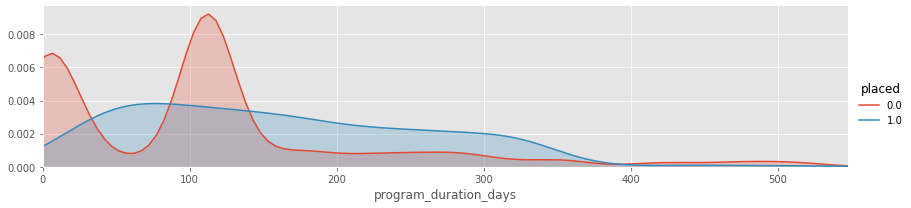

In [11]:
# Program duration days
g = sns.FacetGrid(df, hue = 'placed', aspect=4)
g.map(sns.kdeplot, 'program_duration_days', shade= True)
g.set(xlim=(0, df['program_duration_days'].max()))
g.add_legend();

It seems most of the students are getting placement within the program duration of 50 and 120 days.

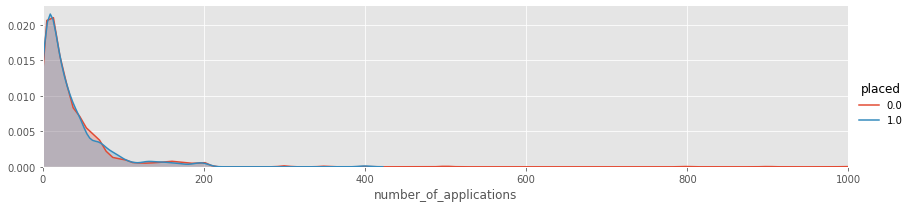

In [12]:
# No of application
g = sns.FacetGrid(df, hue = 'placed', aspect=4)
g.map(sns.kdeplot, 'number_of_applications', shade= True )
g.set(xlim=(0, df['number_of_applications'].max()))
g.add_legend();

Both the distributions for being placed and not being placed are quite same. However, numbers of placements are high just below 20 applications. We may drop this feature.

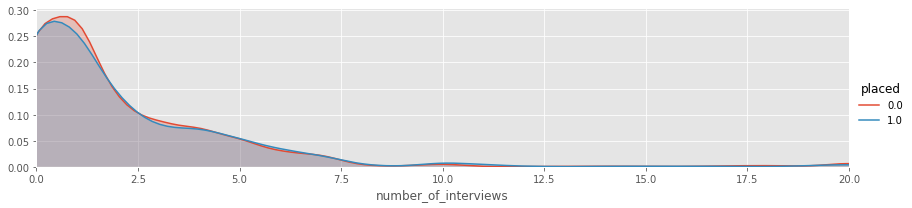

In [13]:
# No of interviews
g = sns.FacetGrid(df, hue = 'placed', aspect=4)
g.map(sns.kdeplot, 'number_of_interviews', shade= True)
g.set(xlim=(0, df['number_of_interviews'].max()))
g.add_legend();

Just like the previous plot. The distributions for both the classes are same. Also, numbers of placement are also high in lower distribution (below 2 interviews). It seems the information isn’t complete.

Let's explore the categorial attributes now. We can plot the most prominent class in every feature and see how these classes are distributed based on the target class of being placed (value 1).

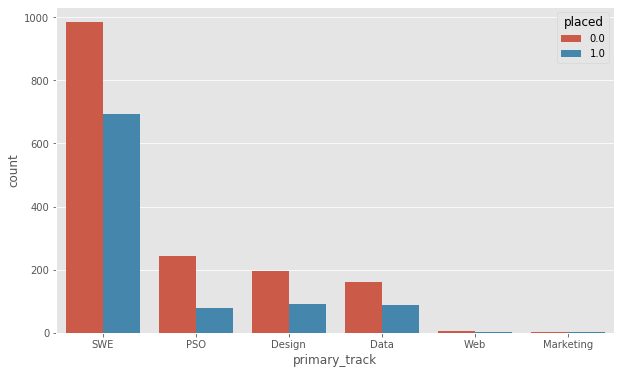

In [14]:
# Primary track
sns.countplot(x = 'primary_track',
              hue='placed',
              data=df);

'SWE' has the highest number of placement record by far. We would check later which class has a better ratio.

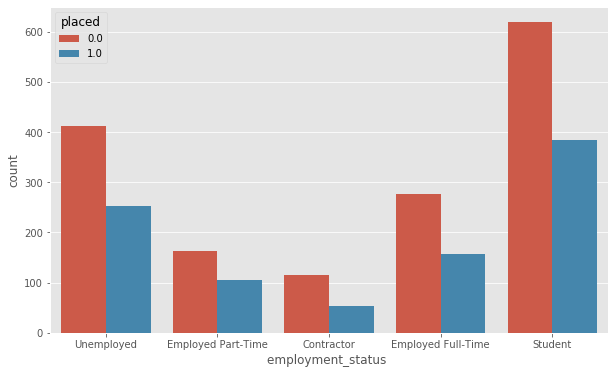

In [15]:
# Employment status
sns.countplot(x = 'employment_status ',
              hue='placed',
              data=df);

Fellows who are 'Student' have the highest number of placement record and 'Employed Part Time' have a better placement ratio.

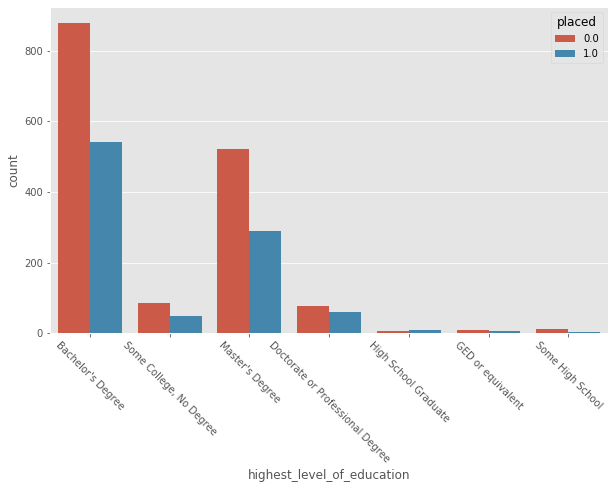

In [16]:
# Highest level of education
sns.countplot(x = 'highest_level_of_education',
              hue='placed',
              data=df)
plt.xticks(rotation=-45);

The fellows with ‘Bachelor's degree’ have the highest number of placements. However, we need to dig deeper to see which educational background has the highest probability.

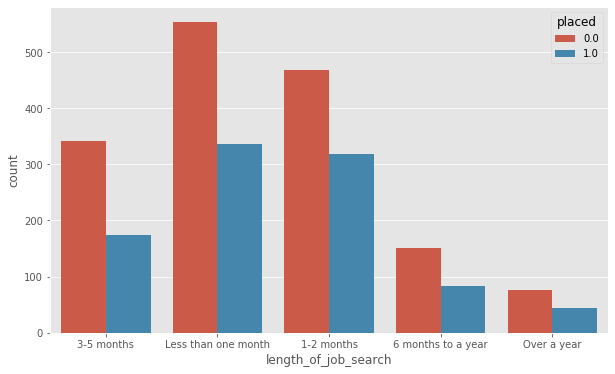

In [17]:
# Length of job search
sns.countplot(x = 'length_of_job_search',
              hue='placed',
              data=df);

The fellows with '1-2 months' job search duration have the highest placement number, whereas it seems they have the highest ratio too.

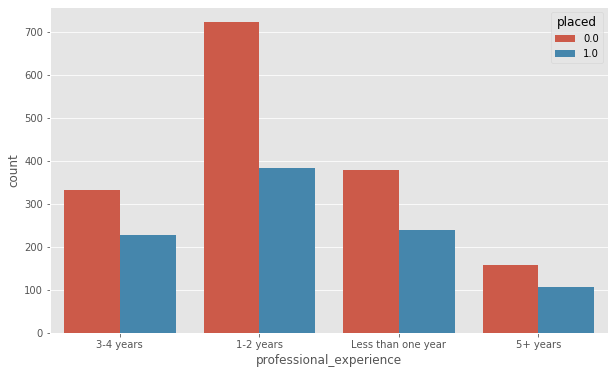

In [18]:
# Professional experience
sns.countplot(x = 'professional_experience',
              hue='placed',
              data=df);

Majority of the Pathrise fellows are having 1-2 years of professional experience and the highest placement numbers too. The ratio is better for the fellows with 5+ years of experience who are surprisingly the minority.

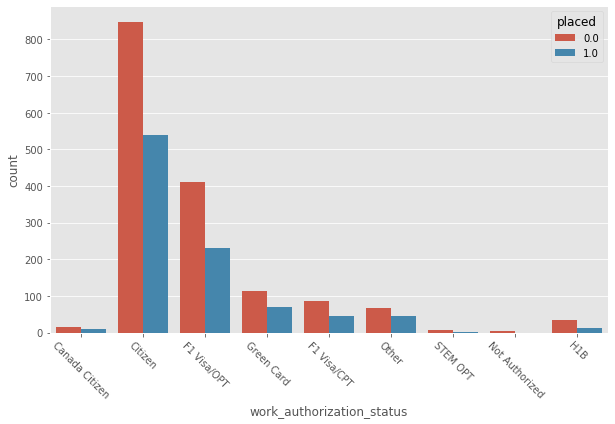

In [19]:
# Work authorization status
sns.countplot(x = 'work_authorization_status',
              hue='placed',
              data=df)
plt.xticks(rotation=-45);

Not surprisingly, most of the fellows are US citizens with F1 Visa/OPT being the second highest.

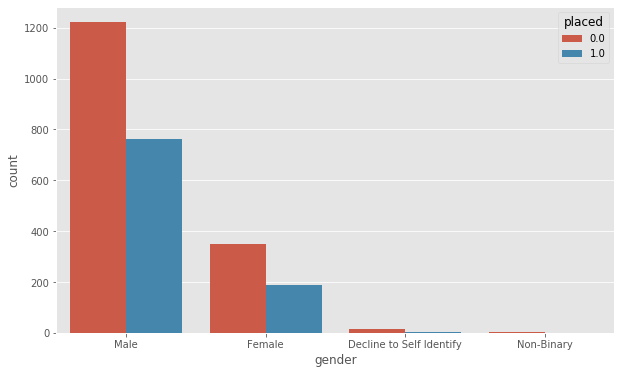

In [20]:
# Gender
sns.countplot(x = 'gender',
              hue='placed',
              data=df);

The numbers go to men but we need to dig deeper to discover which gender group has the highest placement ratio.

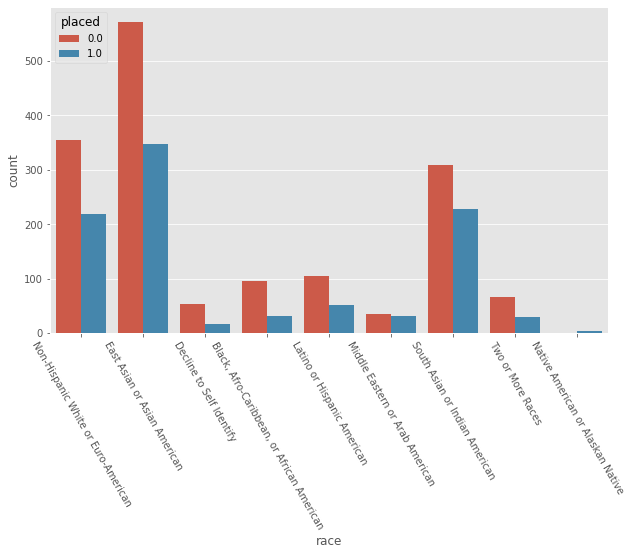

In [21]:
# Race
sns.countplot(x = 'race',
              hue='placed',
              data=df)
plt.xticks(rotation=-60);

Most of the fellows are from the 'East Asian/Asian American' background.

# **Bivariate Analysis**

Let’s dig deeper into seeing how each feature affects the probability of being placed.

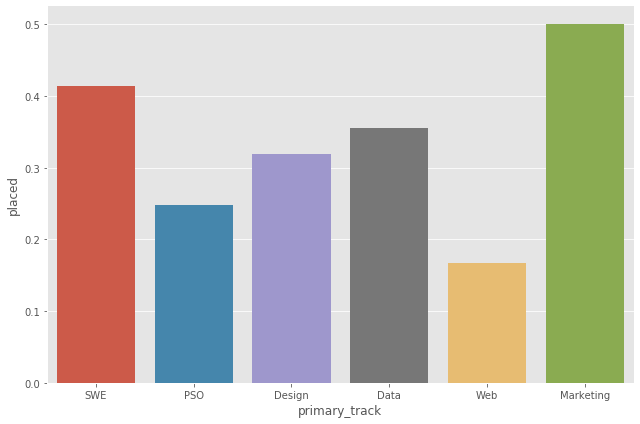

In [22]:
# Primary track and placement
sns.catplot(x='primary_track',
            y='placed',
            data=df,
            kind='bar',
            height=6,
            aspect=1.5,
            ci=None);

In [23]:
df.groupby(['primary_track','placed']).agg({'placed': 'count'})

placed
primary_track placed        
Data          0.0        160
              1.0         88
Design        0.0        196
              1.0         92
Marketing     0.0          1
              1.0          1
PSO           0.0        242
              1.0         80
SWE           0.0        984
              1.0        694
Web           0.0          5
              1.0          1

Although 'Marketing' track has 100 percent placement ration, it has only 1 fellow. If we ignore that, 'SWE' track has the maximum number of fellows being placed as well as best placement ratio.

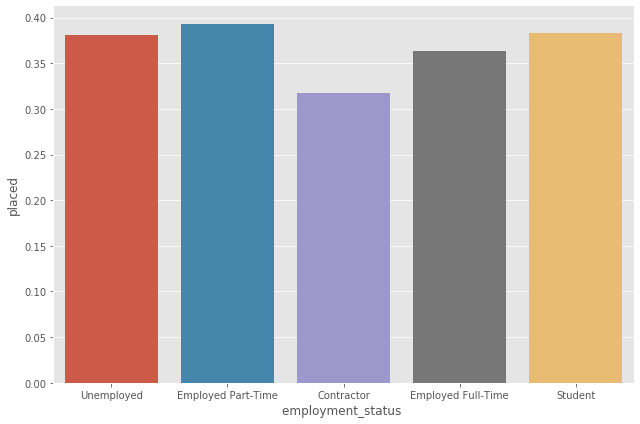

In [24]:
# Primary track and placement
sns.catplot(x='employment_status ',
            y='placed',
            data=df,
            kind='bar',
            height=6,
            aspect=1.5,
            ci=None);

The fellows who are 'Employed Part Time' have the highest probability of being placed, although we have seen 'Student' have the highest numbers of being placed.

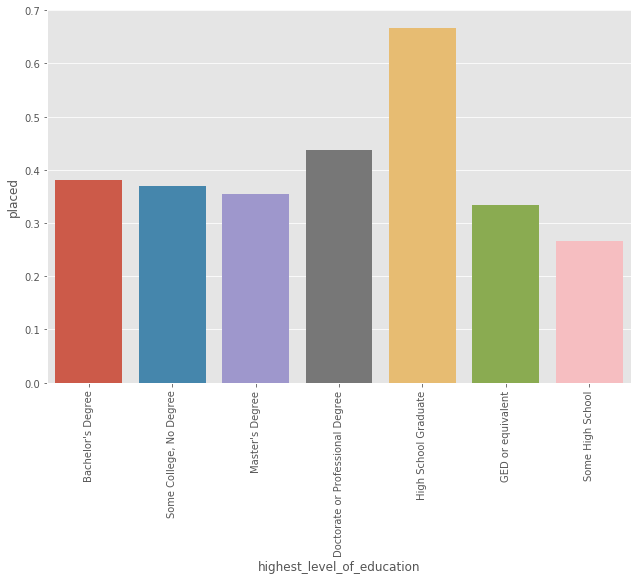

In [25]:
sns.catplot(x='highest_level_of_education',
            y='placed',
            data=df,
            kind='bar',
            height=6,
            aspect=1.5,
            ci=None)
plt.xticks(rotation=90);

In [26]:
df.groupby(['highest_level_of_education','placed']).agg({'placed': 'count'})

placed
highest_level_of_education       placed        
Bachelor's Degree                0.0        879
                                 1.0        540
Doctorate or Professional Degree 0.0         76
                                 1.0         59
GED or equivalent                0.0         10
                                 1.0          5
High School Graduate             0.0          5
                                 1.0         10
Master's Degree                  0.0        522
                                 1.0        288
Some College, No Degree          0.0         85
                                 1.0         50
Some High School                 0.0         11
                                 1.0          4

High-school graduates has the highest probability of being placed. Then come the fellows with 'Doctorate/Professional Degree'. However, the number of 'High School Graduate' fellows are only 15. If we consider that 'Doctorate or Professional Degree' have the highest ratio.

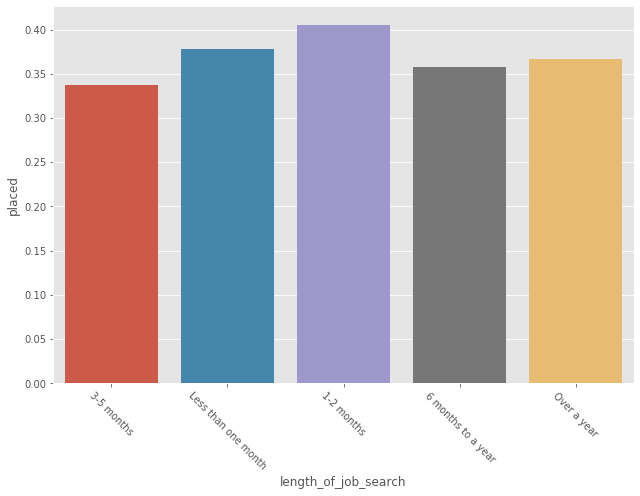

In [27]:
sns.catplot(x='length_of_job_search',
            y='placed',
            data=df,
            kind='bar',
            height=6,
            aspect=1.5,
            ci=None)
plt.xticks(rotation=-45);

The fellows with the duration of 1-2 months job search have both the highest number of presence as well as the highest probability of being placed.

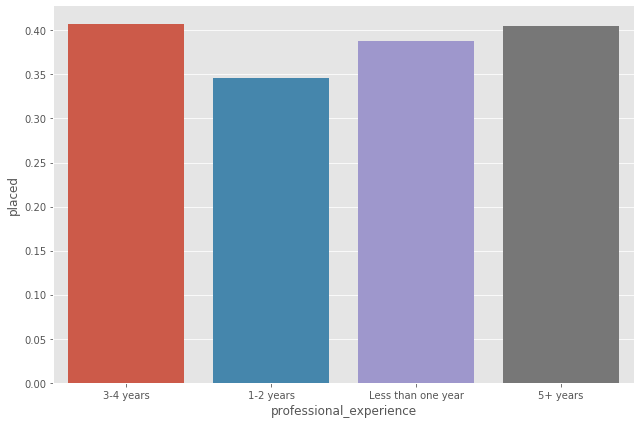

In [28]:
sns.catplot(x='professional_experience',
            y='placed',
            data=df,
            kind='bar',
            height=6,
            aspect=1.5,
            ci=None);

In [29]:
df.groupby(['professional_experience','placed']).agg({'placed': 'count'})

placed
professional_experience placed        
1-2 years               0.0        722
                        1.0        382
3-4 years               0.0        331
                        1.0        227
5+ years                0.0        157
                        1.0        107
Less than one year      0.0        378
                        1.0        240

We have seen before that most of the fellows are having 1-2 years of professional experience; however, the experience of 3-4 years and over 5 years have same kind of probability of being placed. We would prefer fellows with 3-4 years having the best probability of being placed considering their total numbers.

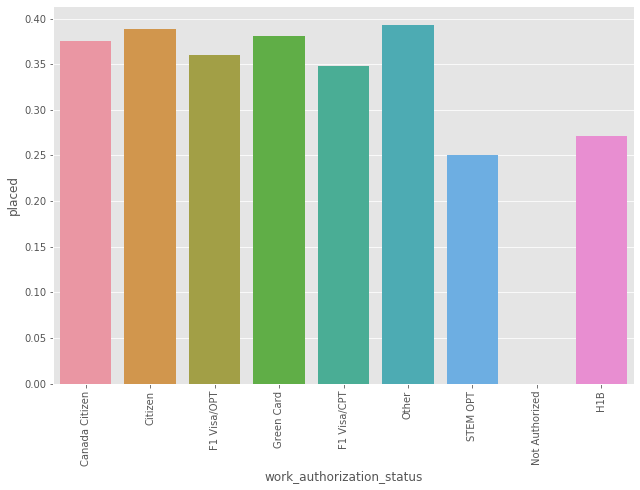

In [30]:
sns.catplot(x='work_authorization_status',
            y='placed',
            data=df,
            kind='bar',
            height=6,
            aspect=1.5,
            ci=None)
plt.xticks(rotation=90);

'Other' class has the highest probability of being placed; however, there is no further details about that. Not sure how 'F1/OPT', 'F1/CPT' and 'F1/Stem' classes are divided.

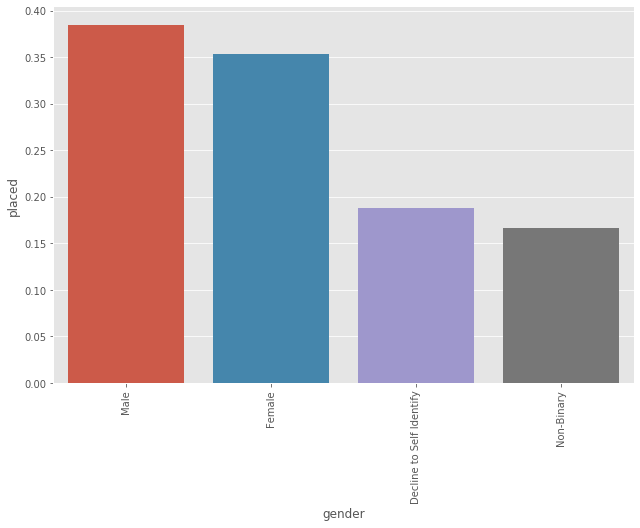

In [31]:
sns.catplot(x='gender',
            y='placed',
            data=df,
            kind='bar',
            height=6,
            aspect=1.5,
            ci=None)
plt.xticks(rotation=90);

Men have the highest probability of being placed among the Pathrise fellows.

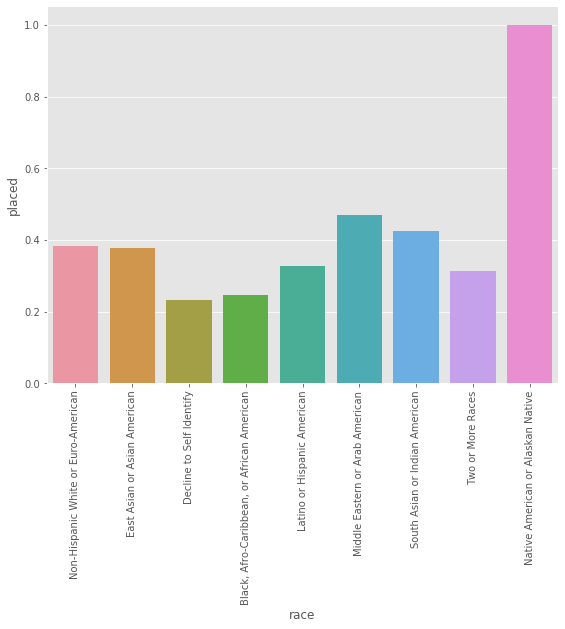

In [32]:
sns.catplot(x='race',
            y='placed',
            data=df,
            kind='bar',
            height=6,
            aspect=1.5,
            ci=None)
plt.xticks(rotation=90);

In [33]:
df.groupby(['race','placed']).agg({'placed': 'count'})

placed
race                                       placed        
Black, Afro-Caribbean, or African American 0.0         95
                                           1.0         31
Decline to Self Identify                   0.0         53
                                           1.0         16
East Asian or Asian American               0.0        571
                                           1.0        347
Latino or Hispanic American                0.0        105
                                           1.0         51
Middle Eastern or Arab American            0.0         35
                                           1.0         31
Native American or Alaskan Native          1.0          3
Non-Hispanic White or Euro-American        0.0        354
                                           1.0        219
South Asian or Indian American             0.0        309
                                           1.0        228
Two or More Races                          0.0         66
                                           1.0         30

The plot shows that all 'Native American or Alaskan Native' fellows are placed; however, there are only 3 fellows. Other than that, 'Middle Eastern or Arab American' fellows have the highest probability of being placed.

# **Multivariate Analysis**

We have seen some interesting relationships between the properties in bivariate plots. Let’s dig deeper and compare those relationships with regards to the placement ratio and primary track.

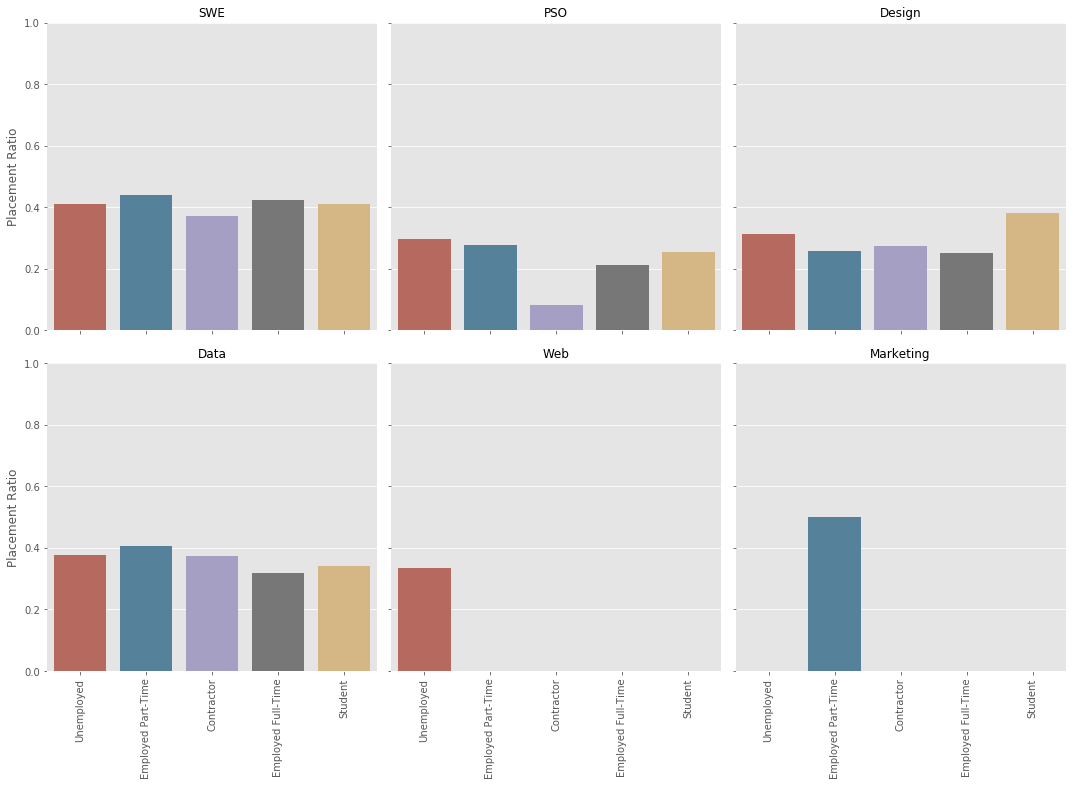

In [34]:
g = sns.catplot(x="employment_status ", y="placed", col="primary_track",
                data=df, saturation=.5, col_wrap = 3,
                kind="bar", ci=None)
(g.set_axis_labels("", "Placement Ratio")
 .set_titles("{col_name}")
 .set_xticklabels(rotation=90)
 .set(ylim=(0, 1))
 .despine(left=True));

We have seen that fellows with 'part_time employment' have the highest placement ratio. If we group the fellows by track, 'part_time employed' fellows have the highest ratio in 3 tracks and then 'employed' fellows with 2. It's surprising that 'student' has highest ratio in only 1, considering they are greater in numbers of being placed.

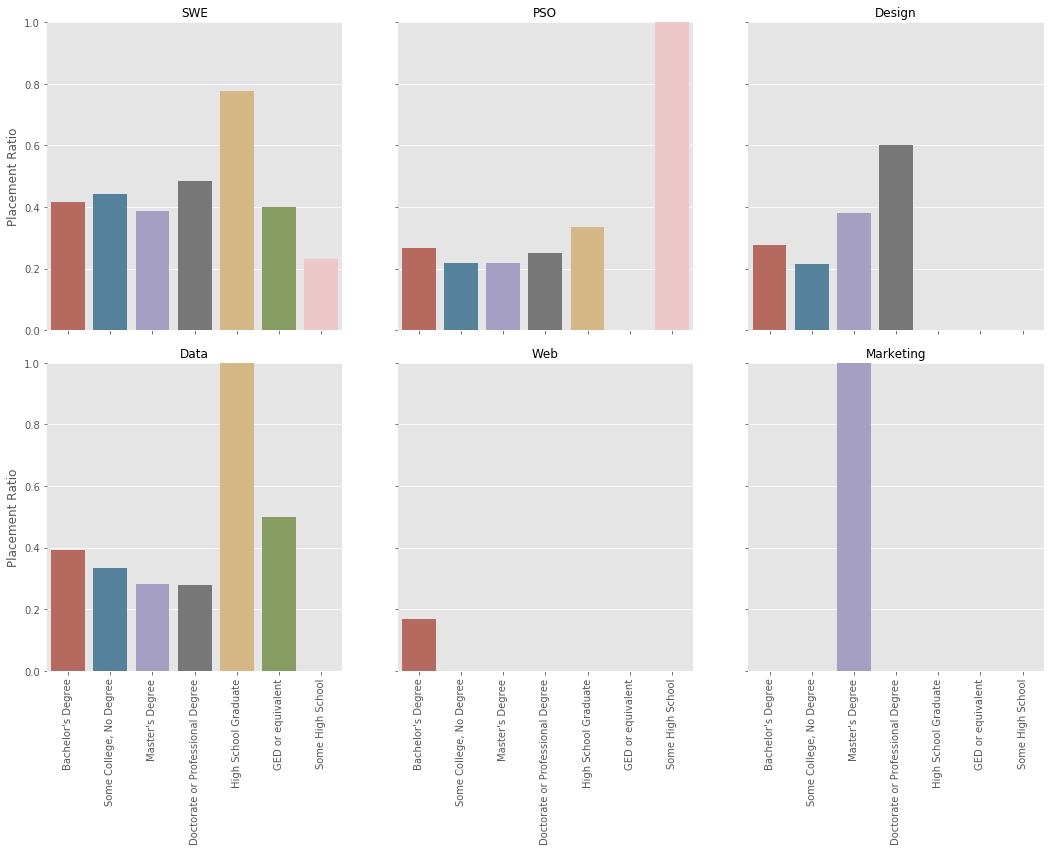

In [35]:
g = sns.catplot(x="highest_level_of_education", y="placed", col="primary_track",
                data=df, saturation=.5, col_wrap = 3,
                kind="bar", ci=None)
(g.set_axis_labels("", "Placement Ratio")
 .set_titles("{col_name}")
 .set_xticklabels(rotation=90)
 .set(ylim=(0, 1))
 .despine(left=True));

Two most popular tracks are 'SWE' and 'Data', and in both the tracks 'High-School Graduate' fellows have the highest placement ratio. However, we have seen their numbers are less, only 15 fellows in total.

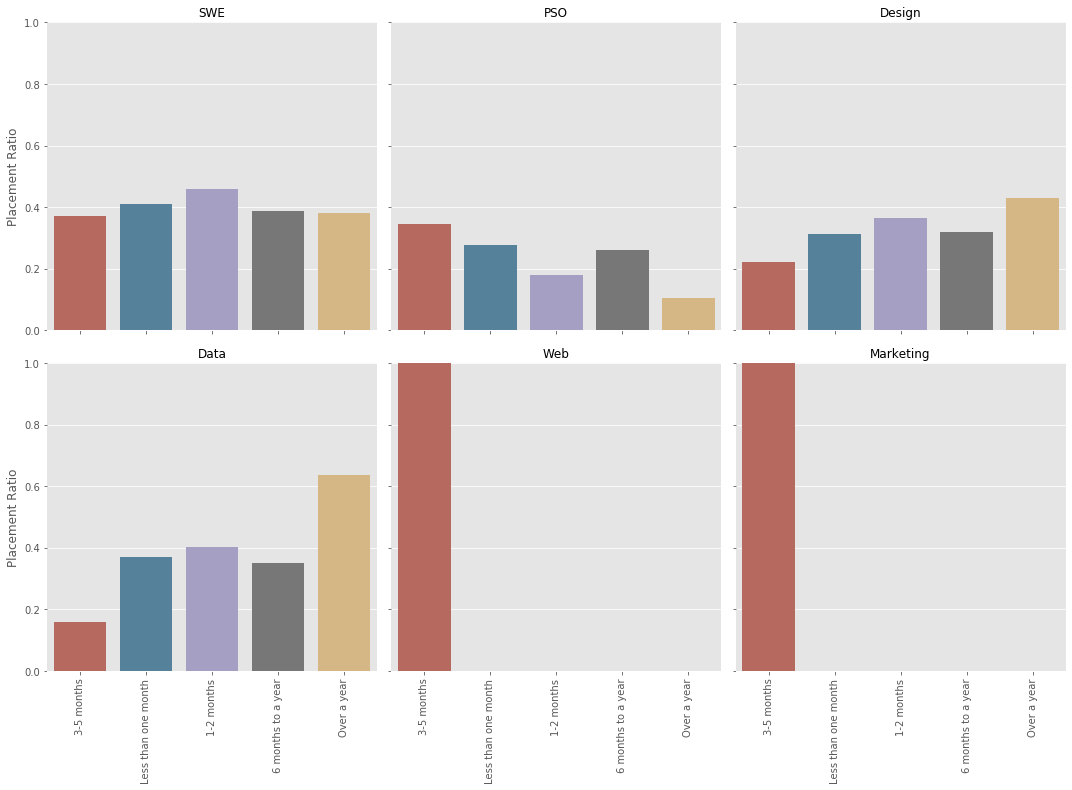

In [36]:
g = sns.catplot(x="length_of_job_search", y="placed", col="primary_track",
                data=df, saturation=.5, col_wrap = 3,
                kind="bar", ci=None)
(g.set_axis_labels("", "Placement Ratio")
 .set_titles("{col_name}")
 .set_xticklabels(rotation=90)
 .set(ylim=(0, 1))
 .despine(left=True));

We have seen the fellows with '1-2' months job search have the highest placement ratio and placement number. Track wise, however, they top only in 'SWE'. Interestingly, all the fellows with '3-5' months job search length have 100 percent placement ration in 'Web' and 'Marketing' tracks.

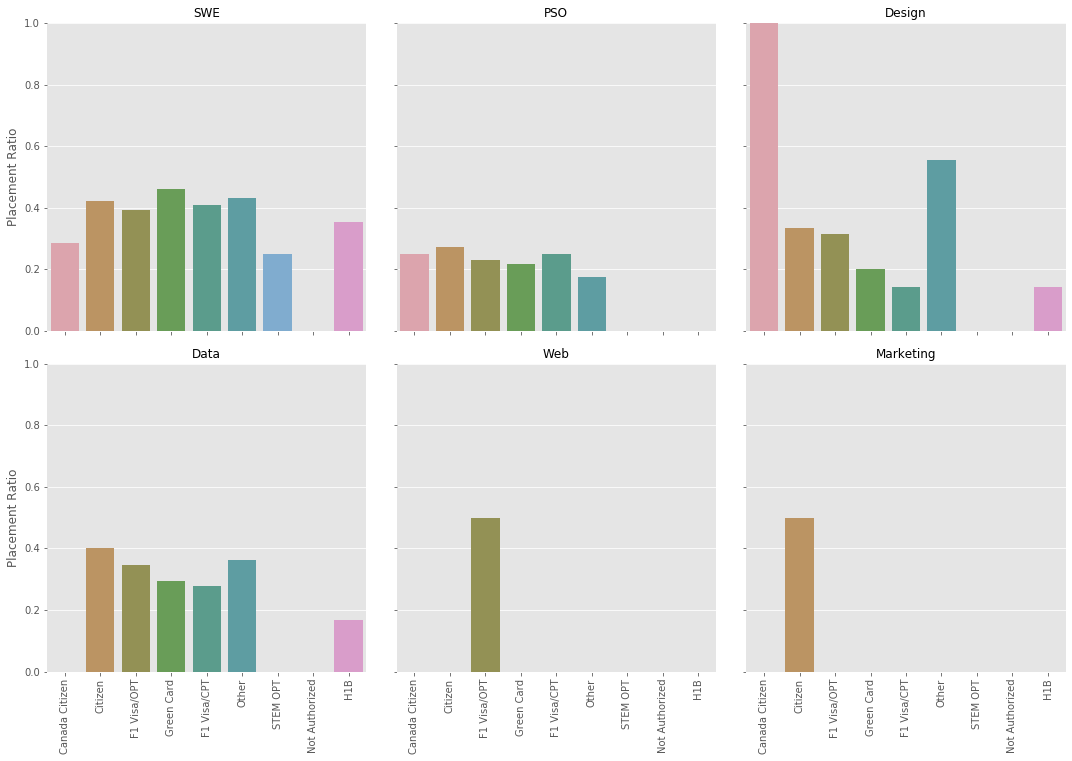

In [37]:
g = sns.catplot(x="work_authorization_status", y="placed", col="primary_track",
                data=df, saturation=.5, col_wrap = 3,
                kind="bar", ci=None)
(g.set_axis_labels("", "Placement Ratio")
 .set_titles("{col_name}")
 .set_xticklabels(rotation=90)
 .set(ylim=(0, 1))
 .despine(left=True));

US citizens holds the majority in placement, whereas 'Others' have the highest overall ratio. Track wise, they vary. In 'SWE', however, it's the 'Green Card' holders who have the highest placement ratio.

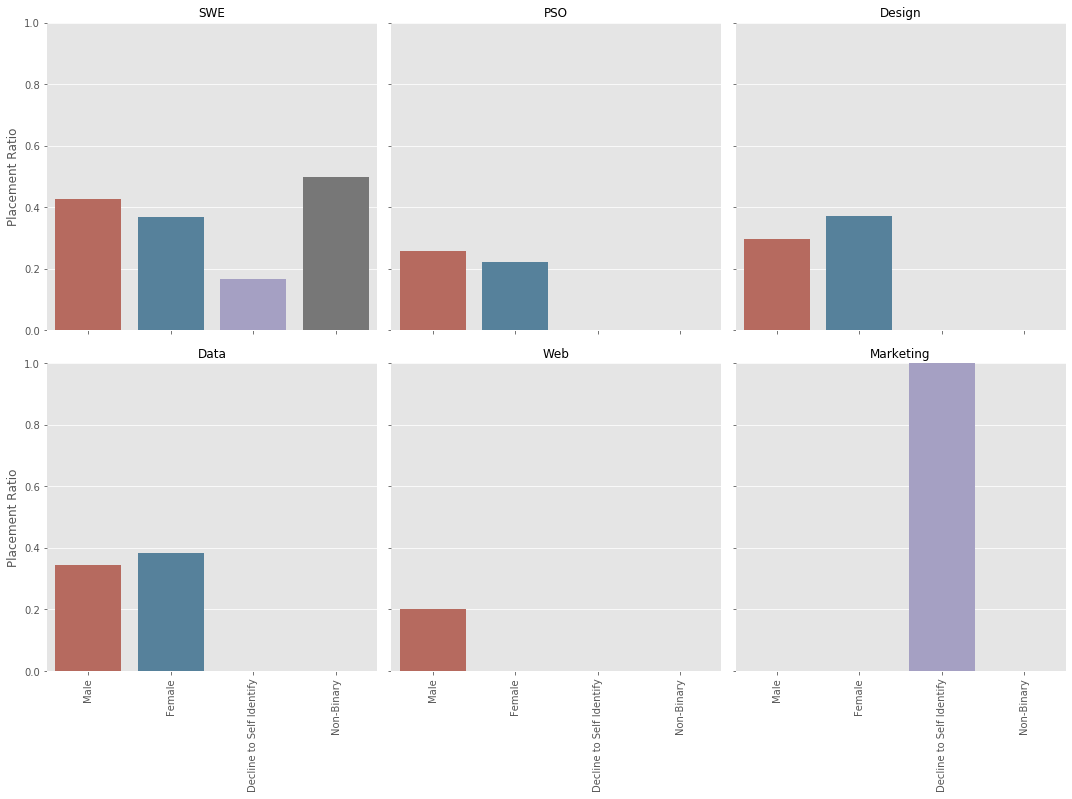

In [38]:
g = sns.catplot(x="gender", y="placed", col="primary_track",
                data=df, saturation=.5, col_wrap = 3,
                kind="bar", ci=None)
(g.set_axis_labels("", "Placement Ratio")
 .set_titles("{col_name}")
 .set_xticklabels(rotation=90)
 .set(ylim=(0, 1))
 .despine(left=True));

Men are way ahead than others in majority or in placement ratio. However, track wise, men top only in 'PSO' track. In 'SWE', 'Non-Binary' fellows have the highest ratio who are 4 in numbers though. In 'Data' track, women lead the ratio of being placed.

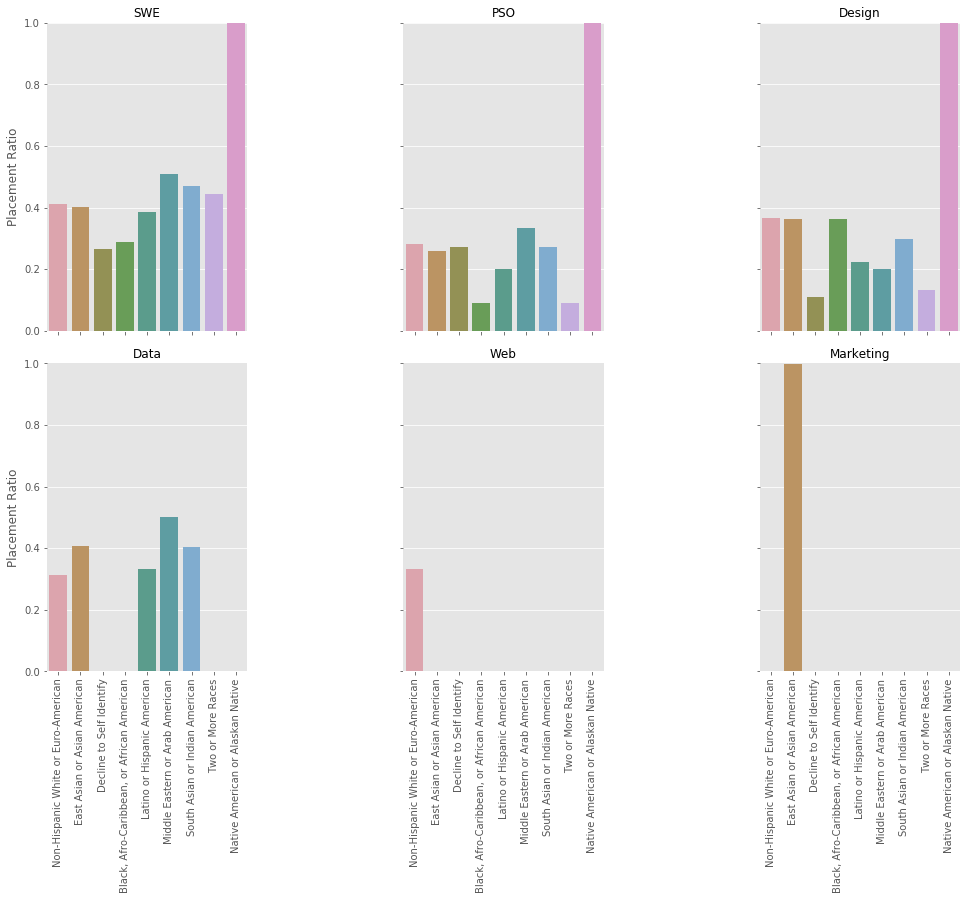

In [39]:
g = sns.catplot(x="race", y="placed", col="primary_track",
                data=df, saturation=.5, col_wrap = 3,
                kind="bar", ci=None)
(g.set_axis_labels("", "Placement Ratio")
 .set_titles("{col_name}")
 .set_xticklabels(rotation=90)
 .set(ylim=(0, 1))
 .despine(left=True));

We have seen 'Native American or Alaskan Native' fellows have 100 percent placement ratio but they are only 3 fellows. Other than that, 'Middle Eastern or Arab American' fellows have the highest probability of being placed in two-most popular tracks of 'SWE' and 'Data'.

# **Assumptions for Classification**

We have arrived at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

**Correlating**
<br>
We want to know how well does each feature correlate with being placed.

**Correcting**
1.	‘pathrise_status’ feature may be dropped from our analysis as it is leaking the data.
2.	‘number_of_applications’ and ‘number_of_interviews’ features may be dropped as they seems incomplete and having same distribution for both the classes.
3.	'id', 'cohort_tag', and 'biggest_challenge_in_search' may be dropped from training dataset as they don’t contribute to placed.
4.	‘employment_status’ feature may not contribute directly to placed, so maybe dropped.

**Classifying**
<br>
We may also add to our assumptions based on our analysis via plots.
1.	SWE track (primary_track=SWE) is more likely to be placed.
2.	Part-time employed fellows (employment_status=Employed Part-Time) are more likely to be placed.
3.	Fellows with 'Doctorate or Professional Degree' (highest_level_of_education=Doctorate or Professional Degree) are more likely to be placed.
4.	Men (gender=male) are more likely to be placed.
5.	Middle Eastern or Arab American fellows (race= Middle Eastern or Arab American) have the highest probability of being placed after ‘Others’ class which isn’t clear.

# **Preprocessing Dataset**

Let's start by checking the distribution of each numeric attribute.

In [40]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = df.corr()
corr.sort_values(["placed"], ascending = False, inplace = True)
print(corr.placed)

Find most important features relative to target
placed                    1.000000
program_duration_days     0.217611
number_of_interviews     -0.005816
number_of_applications   -0.028364
Name: placed, dtype: float64


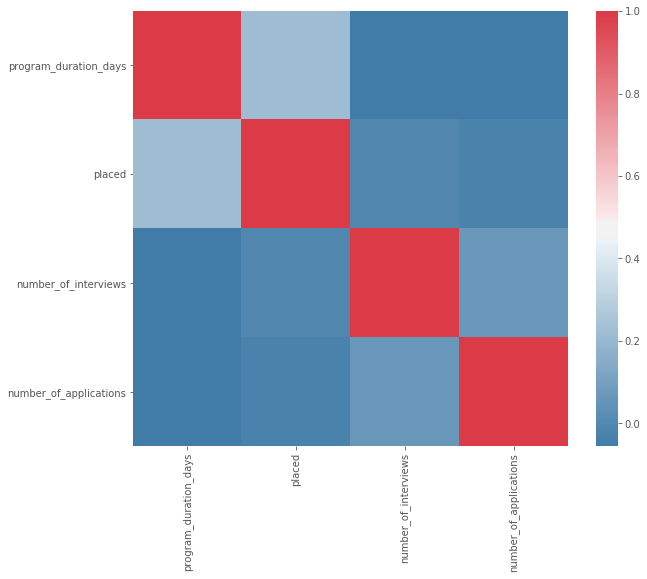

In [41]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax);

Let's drop not so important features.

In [42]:
# Drop not-so important features
col_to_drop = ['pathrise_status', 'number_of_interviews', 'number_of_applications']
df_new = df.drop(columns=col_to_drop)
df_new.sample()

,program_duration_days,placed,primary_track,employment_status,highest_level_of_education,length_of_job_search,professional_experience,work_authorization_status,gender,race
1490,112.0,0.0,SWE,Student,"Some College, No Degree",1-2 months,3-4 years,Citizen,Male,East Asian or Asian American


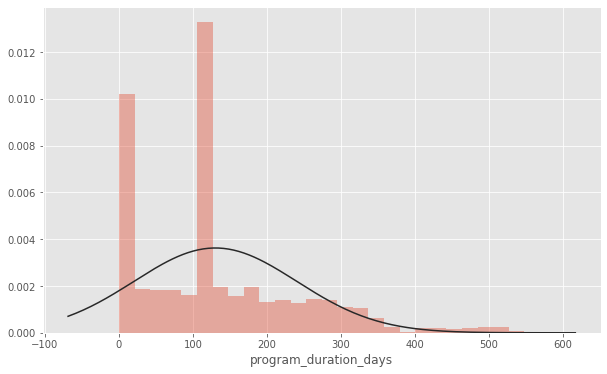

In [43]:
# Check the distribution 
sns.distplot(df_new['program_duration_days'], fit=norm, kde=False);

In [44]:
# Log transform the numeric features
df_new['program_duration_days'] = np.log1p(df_new['program_duration_days'])
df_new['program_duration_days'].describe().T

count    2544.000000
mean        4.164876
std         1.659334
min         0.000000
25%         3.713572
50%         4.727388
75%         5.220356
max         6.308098
Name: program_duration_days, dtype: float64

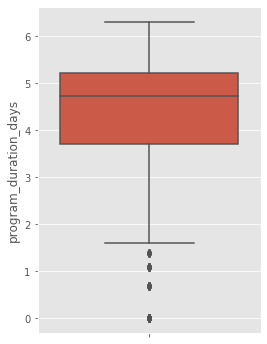

In [45]:
# Box and whisker plots to check outliers
sns.boxplot(y=df_new['program_duration_days']);
plt.gcf().set_size_inches(4,6);

In [46]:
# Subset features
numeric_cols = df_new.select_dtypes(include=[np.number])
categoric_cols = df_new.select_dtypes(include=[object])

# Instantiate labelencoder
le = LabelEncoder()

# Apply on categorical feature columns
df_categorical = categoric_cols.apply(lambda col: le.fit_transform(col))

In [47]:
# Join categorical and numerical features
df_final = pd.concat([numeric_cols, df_categorical], axis = 1)

# Get variables for the model
y = df_final['placed']
X = df_final.drop('placed', axis=1)

In [48]:
# Spliting up the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.30, 
                                                    random_state=42)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1780, 9)
X_test : (764, 9)
y_train : (1780,)
y_test : (764,)


In [49]:
# Instantiate the scaler
scaler = StandardScaler()

# Fit and transform train dataset
X_train = scaler.fit_transform(X_train)

# Transform the test dataset
X_test = scaler.transform(X_test)

# **Building the Classifier**

In [50]:
# Define a classifier list that contains the tuples (classifier name, classifier)
classifiers = [('LogReg', LogisticRegression(max_iter=10000)),
               ('SVM', SVC(probability=True)),
               ('DecisionTree', DecisionTreeClassifier()),
               ('RandomForest', RandomForestClassifier()),
               ('AdaBoost', AdaBoostClassifier()),
               ('XGB', XGBClassifier(objective='binary:logistic'))]

## Evaluate Algorithms: Baseline

All the algorithms use default tuning parameters. We will display the mean and standard deviation of ROC score for each algorithm as we calculate them and collect the results for later use.

In [51]:
# Set kfold
kfold = KFold(n_splits=10)

print('The AUC score...')
results = []
names = []
for name, model in classifiers:
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_score)
    names.append(name)
    print(f'{name}: {cv_score.mean()}, {cv_score.std()}')

The AUC score...
LogReg: 0.6741361617219948, 0.03540564039402418
SVM: 0.6451025126451528, 0.03439525650140502
DecisionTree: 0.750815566472846, 0.049148496538966135
RandomForest: 0.8789312083265763, 0.028132701464167523
AdaBoost: 0.878637290771238, 0.0328107384316698
XGB: 0.8862297766888572, 0.023097725775539743


The results suggest that XGBoost is way ahead of other classifiers.

## Compare the Algorithms

These are just mean ROC values. Let's take a look at the distribution of ROC values across different cross-validation folds, using box and whisker plots.

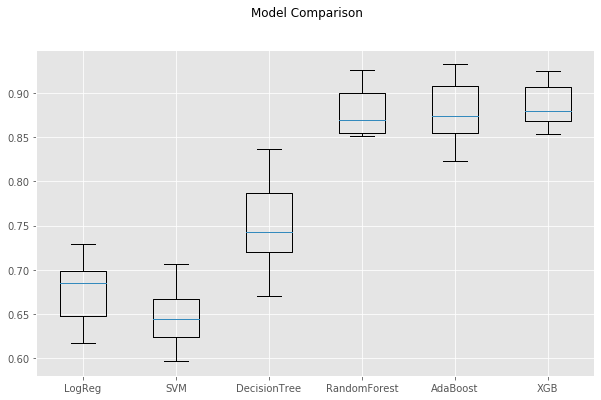

In [52]:
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names);

The results show XGBoost is little ahead than Ada Boost. It also has a tigher distribution, which is good for prediction. So we consider XGBoost as our final algorithm for prediction.

## Tuning XGBoost

We can tune a couple of key parameters of the XGBoost algorithm. We will perform a grid search using 10-fold cross-validation.

In [53]:
# Create the parameter grid
xgb_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 5]
}

# Instantiate the classifier
xgb_clf = XGBClassifier(objective='binary:logistic')

# Perform grid search
grid = GridSearchCV(estimator=xgb_clf,
                    param_grid=xgb_param_grid,
                    scoring='roc_auc',
                    cv=kfold, verbose=1,
                    n_jobs=4)

# Fit the estimator
grid.fit(X_train, y_train)

# Compute metrics
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    2.7s


Best: 0.894913 using {'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 100}


[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    4.1s finished


We can see the best configuration for the XGBoost algorithm was with 100 trees, ‘max_depth' of 2 and 0.7 colsample_bytree'. The RUC score 89% is seemingly better too.

## Finalize the Model

XGBoost showed the most promise for this problem. We will now finalize the model by training it on the entire training dataset and make predictions for the hold-out validation dataset to confirm our findings.

In [54]:
# Find the best paramaters
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
def get_model_results(X_train, y_train, X_test, y_test, model):
    """
    A function that returns performance scores of a classifier 
    """
    # Fit model to training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model 
    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

In [56]:
# Finalize the model
final_model = grid.best_estimator_

# Estimate results on validation dataset
get_model_results(X_train, y_train, X_test, y_test, final_model)

ROC Score:
0.8788486402384239

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.80      0.85       477
         1.0       0.72      0.84      0.78       287

    accuracy                           0.82       764
   macro avg       0.81      0.82      0.81       764
weighted avg       0.83      0.82      0.82       764


Confusion Matrix:
[[383  94]
 [ 45 242]]


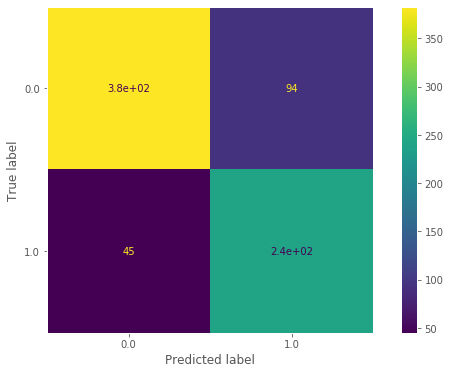

In [57]:
# Plot confision matrix
plot_confusion_matrix(final_model, X_test, y_test)  # doctest: +SKIP
plt.grid(False)
plt.show()

## Get the Predictions

In [58]:
predictions = final_model.predict(X_test)
solution1 = pd.DataFrame({'Predictions': predictions})
solution1.head()

,Predictions
0,1.0
1,1.0
2,0.0
3,1.0
4,0.0


# **Recommendations**

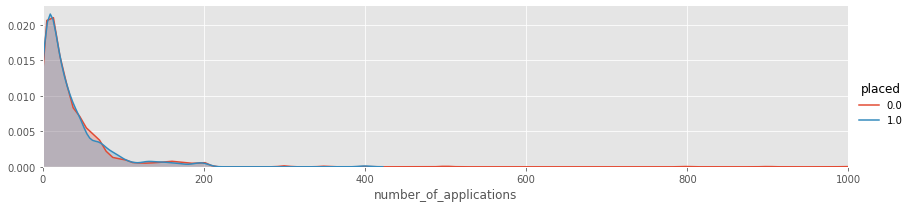

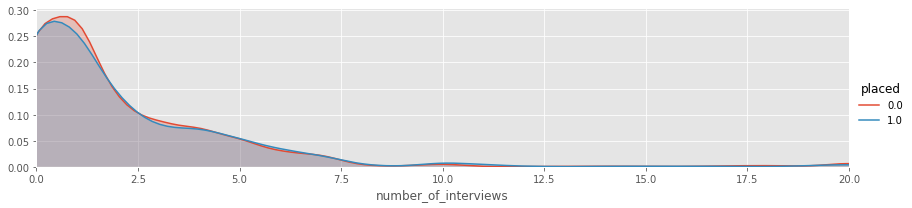

In [59]:
col_to_plot = ['number_of_applications', 'number_of_interviews']

for col in col_to_plot:
    g = sns.FacetGrid(df, hue = 'placed', aspect=4)
    g.map(sns.kdeplot, col, shade= True)
    g.set(xlim=(0, df[col].max()))
    g.add_legend();

## Recommendation 1

### We can observe from the plots that the distributions for being placed and not being placed are quite same in the ‘number_of_applications’ and  ‘number_of_interviews’ attributes. Also, the success rate is too high when their values are low, which is rarely a real-life scenario. Pathrise may need to concentrate on a better data collection strategy for these two features.

## Recommendation 2

In [60]:
df.groupby(['work_authorization_status','placed']).agg({'placed': 'count'})

placed
work_authorization_status placed        
Canada Citizen            0.0         15
                          1.0          9
Citizen                   0.0        848
                          1.0        540
F1 Visa/CPT               0.0         86
                          1.0         46
F1 Visa/OPT               0.0        412
                          1.0        232
Green Card                0.0        114
                          1.0         70
H1B                       0.0         35
                          1.0         13
Not Authorized            0.0          4
Other                     0.0         68
                          1.0         44
STEM OPT                  0.0          6
                          1.0          2

### 'F1/Stem' can also be part of 'F1/OPT' and 'F1/CPT'. Considering that,  Pathrise may need a better strategy to group the work_authorization_status feature.